<a href="https://colab.research.google.com/github/Raniamea/arabic-video-summarisation/blob/main/notebooks/CustomTrainingOnTranscripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =========================================================
# Mount Google Drive and define base path
# =========================================================
from google.colab import drive
import os

if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive", force_remount=False)

# Define base path for project files
BASE_PATH = "/content/drive/MyDrive/ArabicVideoSummariser"
os.makedirs(BASE_PATH, exist_ok=True)

Mounted at /content/drive


In [2]:
!pip install -q \
  "transformers==4.46.3" \
  "huggingface-hub==0.35.3" \
  "tokenizers==0.20.3" \
  "datasets==2.19.1" \
  "evaluate>=0.4.2,<0.5.0"  \
  "rouge-score==0.1.2" \
  "bert-score==0.3.13" \
  "matplotlib==3.8.4" \
  "pandas==2.2.2" \
  "accelerate>=0.30.0,<0.35.0"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [3]:
# ---- Clean up warning ----
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# ============================================================
# Custom Fine-Tuning on Arabic Transcript–Summary Pairs
# (ROUGE-L + BERTScore + LaBSE)
# ============================================================

import os, torch, evaluate, numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer,
    EarlyStoppingCallback
)
from sentence_transformers import SentenceTransformer, util
from bert_score import score as bert_score_fn
from rouge_score import rouge_scorer, scoring

BASE_DIR = "/content/drive/MyDrive/ArabicVideoSummariser"
EXCEL_PATH = os.path.join(BASE_DIR, "transcripts.xlsx")

import transformers
transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load dataset ----
df = pd.read_excel(EXCEL_PATH)
df = df.dropna(subset=['transcript', 'summary']).reset_index(drop=True)

# ---- Split into train / val / test (80 / 10 / 10) ----
train_df, val_df, test_df = np.split(
    df.sample(frac=1, random_state=42),
    [int(0.8 * len(df)), int(0.9 * len(df))]
)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

# ---- Base model ----
#BASE_MODEL = "csebuetnlp/mT5_multilingual_XLSum"
#BASE_MODEL = "moussaKam/AraBART"

BASE_MODEL = "ahmeddbahaa/AraBART-finetuned-ar"
MODEL_NAME = BASE_MODEL.split("/")[-1]
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=False)

max_input_length = 1024 #512
max_target_length = 400 #128

def preprocess(batch):
    model_inputs = tokenizer(batch["transcript"], max_length=max_input_length, truncation=True)
    labels = tokenizer(batch["summary"], max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_ds = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

# ---- Metrics ----
def load_metrics():
       rouge = evaluate.load("rouge")
       bertscore = evaluate.load("bertscore")
       sem_model = SentenceTransformer("sentence-transformers/LaBSE").to(device)
       return rouge, bertscore, sem_model

rouge, bertscore, sem_model = load_metrics()


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.where(preds < 0, 0, preds)
    preds = np.where(preds >= tokenizer.vocab_size, 0, preds)
    labels = np.where(labels < 0, 0, labels)
    labels = np.where(labels >= tokenizer.vocab_size, 0, labels)

    decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds  = [p.strip() if p.strip() else "[EMPTY]" for p in decoded_preds]
    decoded_labels = [l.strip() if l.strip() else "[EMPTY]" for l in decoded_labels]

    # ---- ROUGE-L ----
    r = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    rougeL = float(r.get("rougeL", 0.0))

    # ---- BERTScore ----
    b = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ar")
    f1_values = b.get("f1", 0.0)
    bert_f1_mean = float(np.mean(f1_values)) if isinstance(f1_values, (list, np.ndarray)) else float(f1_values)

    # ---- Semantic similarity (LaBSE) ----
    emb_pred = sem_model.encode(decoded_preds, convert_to_tensor=True, show_progress_bar=False)
    emb_ref  = sem_model.encode(decoded_labels, convert_to_tensor=True, show_progress_bar=False)
    cosine_scores = util.cos_sim(emb_pred, emb_ref).diagonal().detach().cpu().numpy()
    semantic_mean = float(np.mean(cosine_scores))

    return {
        "rougeL": rougeL,
        "bertscore_f1": bert_f1_mean,
        "semantic_sim": semantic_mean
    }

# ---- Load model ----
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(device)

# ---- Training setup ----
args = Seq2SeqTrainingArguments(
    output_dir=f"/content/{MODEL_NAME}_finetuned_ROUGEL_SEMANTIC",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="semantic_sim",
    greater_is_better=True,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    predict_with_generate=True,
    generation_max_length=max_target_length,
    logging_strategy="epoch",
    report_to="none",
    disable_tqdm=True
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ---- Train ----
trainer.train()

# ---- Evaluate on test set ----
metrics = trainer.evaluate(tokenized_ds["test"])
wanted = {k: v for k, v in metrics.items() if k in (
    "eval_rougeL", "eval_bertscore_f1", "eval_semantic_sim"
)}
print("\n===== Average Test Metrics =====")
for k in ["eval_rougeL", "eval_bertscore_f1", "eval_semantic_sim"]:
    if k in wanted and isinstance(wanted[k], (int, float)):
        print(f"{k}: {wanted[k]:.4f}")


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

{'loss': 4.7672, 'grad_norm': 4.699000835418701, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.0}


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 4.069289207458496, 'eval_rougeL': 0.0, 'eval_bertscore_f1': 0.7063123252656724, 'eval_semantic_sim': 0.5627126693725586, 'eval_runtime': 7.3001, 'eval_samples_per_second': 2.466, 'eval_steps_per_second': 0.685, 'epoch': 1.0}
{'loss': 4.0906, 'grad_norm': 4.724888801574707, 'learning_rate': 2.5e-05, 'epoch': 2.0}
{'eval_loss': 3.9857535362243652, 'eval_rougeL': 0.037037037037037035, 'eval_bertscore_f1': 0.7088287605179681, 'eval_semantic_sim': 0.5892081260681152, 'eval_runtime': 4.1846, 'eval_samples_per_second': 4.301, 'eval_steps_per_second': 1.195, 'epoch': 2.0}
{'loss': 3.7801, 'grad_norm': 4.824524402618408, 'learning_rate': 1.25e-05, 'epoch': 3.0}
{'eval_loss': 3.9591152667999268, 'eval_rougeL': 0.05555555555555555, 'eval_bertscore_f1': 0.71345098151101, 'eval_semantic_sim': 0.6347506046295166, 'eval_runtime': 4.4187, 'eval_samples_per_second': 4.074, 'eval_steps_per_second': 1.132, 'epoch': 3.0}
{'loss': 3.5931, 'grad_norm': 4.618363380432129, 'learning_rate': 0.0, 

In [6]:
# ============================================================
#  Save Fine-Tuned Model to Drive
# ============================================================
import os
from datetime import datetime

# ---- Define target path ----
SAVE_ROOT = os.path.join(BASE_DIR, "models")
os.makedirs(SAVE_ROOT, exist_ok=True)

# Create timestamped folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = os.path.join(SAVE_ROOT, f"{MODEL_NAME}_finetuned_{timestamp}")
os.makedirs(save_dir, exist_ok=True)


# ---- Save model, tokenizer, and generation config ----
try:
    model.save_pretrained(save_dir, safe_serialization=False)
    tokenizer.save_pretrained(save_dir)
    if hasattr(model, "generation_config"):
        model.generation_config.save_pretrained(save_dir)
        print(f"Saved fine-tuned model to: {save_dir}")
except Exception as e:
    print(f" Save failed: {e}")

# ---- save metrics summary ----
metrics_path = os.path.join(save_dir, "final_test_metrics.txt")
try:
    with open(metrics_path, "w", encoding="utf-8") as f:
        f.write("===== Final Test Metrics =====\n")
        for k, v in wanted.items():
            f.write(f"{k}: {v:.4f}\n")
    print(f"Metrics saved to {metrics_path}")
except Exception as e:
    print(f" Metrics file not written: {e}")


Saved fine-tuned model to: /content/drive/MyDrive/ArabicVideoSummariser/models/AraBART-finetuned-ar_finetuned_20251110_1546
Metrics saved to /content/drive/MyDrive/ArabicVideoSummariser/models/AraBART-finetuned-ar_finetuned_20251110_1546/final_test_metrics.txt


Generating summaries for the test set...
Saved per-sample metrics → /content/drive/MyDrive/ArabicVideoSummariser/models/AraBART-finetuned-ar_finetuned_20251110_1546/test_full_metrics.csv

===== AraBART-finetuned-ar =====
Mean ROUGE-L: 0.00%
Mean BERTScore F1: 71.75%
Mean LaBSE Semantic-Sim: 63.09%


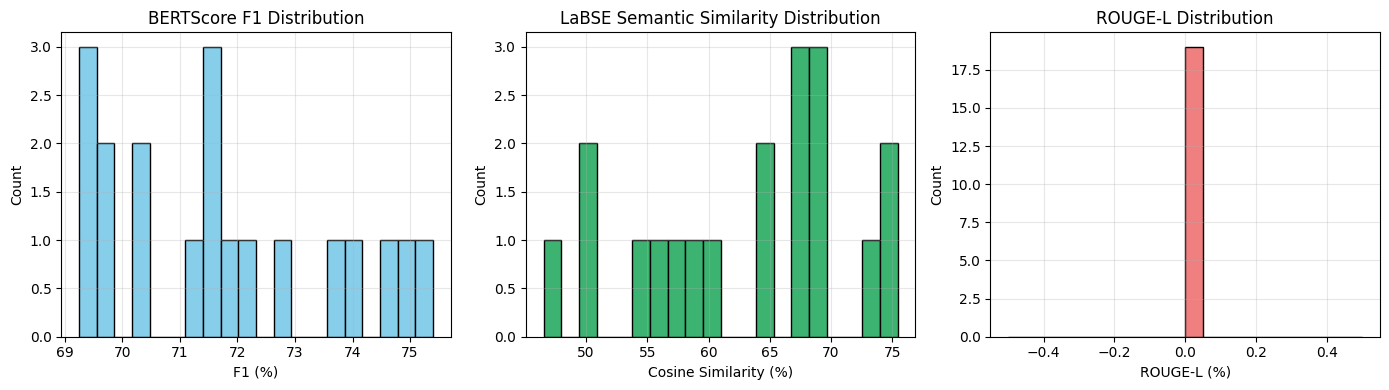


===== Qualitative Test Samples =====

BEST SAMPLE (Semantic Similarity)
[idx=12] | ROUGE-L: 0.00% | BERT F1: 74.77% | Semantic-Sim: 75.44%

Transcript (snippet):
ببساطة، ده مش اسم المكان، ده اسلوب حياة. على بعد 20 كيلو متراً من مدينة نويبا، على ساحل خليج العقبة،
تقع قرية بساطة. استطاع صاحبها أن يحول السحراء القاحلة إلى قطعة من الجنة. حارب وكافح الكثير لينجح
مشروعه. الحقيقة، أنا أصلاً مهندس، لكن ما فاهمش حاجة في السياحة إطلاقاً. أصلاً مهندس، لكن قررت من
زمان قوي إن أنا أهاجر من …

Reference:
على خليج العقبة، قام مهندس من القاهرة بتحويل صحراء قاحلة إلى جنة اسمها "بساطة". المكان ليس مجرد قرية
سياحية، بل فلسفة حياة: بناء بالمواد الطبيعية، تعليم الأطفال، والعيش بتناغم مع البحر والجبل. هنا
يتعلم الناس أن السعادة ليست في الرفاهية، بل في البساطة التي تعيدنا إلى جذورنا.

Prediction:
قرية "العودة" في خليج العقبة، تحولت إلى قرية منسية، تجمع بين الجمال والبحر والجبل. هنا يتعلم الناس
من الطبيعة، يتعلمون منها، ويتعلمون من حولها، ويبنوا بيوتا خضراء. رغم التحديات، يبقى حلمهم أن يصبحوا
مجتمعا نابضا با

In [7]:
# ============================================================
# TEST-SET EVALUATION (ROUGE-L + BERTScore + LaBSE Semantic-Sim)
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap, random, os, evaluate, warnings, torch
from sentence_transformers import SentenceTransformer, util

# --- Helper Function ---
def safe_batch_decode(tokenizer, sequences):
    vocab = tokenizer.vocab_size
    clean = []
    for seq in sequences:
        if isinstance(seq, np.ndarray): seq = seq.tolist()
        seq = [int(i) for i in seq if 0 <= i < vocab]
        clean.append(seq or [tokenizer.pad_token_id])
    return tokenizer.batch_decode(clean, skip_special_tokens=True)

# --- Generate predictions ---
print("Generating summaries for the test set...")
pred_out = trainer.predict(tokenized_ds["test"], max_length=128)
pred_ids = pred_out.predictions[0] if isinstance(pred_out.predictions, tuple) else pred_out.predictions
pred_texts = safe_batch_decode(tokenizer, pred_ids)

ref_texts = list(dataset["test"]["summary"])
src_texts = list(dataset["test"]["transcript"])


# --- ROUGE & BERTScore & LaBSE ---
rouge_scores = rouge.compute(predictions=pred_texts, references=ref_texts)
bert_scores = bertscore.compute(predictions=pred_texts, references=ref_texts, lang="ar")

rougeL_per_sample = []
semantic_sim_per_sample = []

for p, r in zip(pred_texts, ref_texts):
    # ROUGE-L
    tmp = rouge.compute(predictions=[p], references=[r])
    rougeL = tmp.get("rougeL", 0.0) * 100
    rougeL_per_sample.append(rougeL)

    # LaBSE Semantic Similarity
    emb_pred = sem_model.encode(p, convert_to_tensor=True)
    emb_ref  = sem_model.encode(r, convert_to_tensor=True)
    sim = float(util.cos_sim(emb_pred, emb_ref).cpu().item()) * 100
    semantic_sim_per_sample.append(sim)

bert_f1_per_sample = np.array(bert_scores["f1"]) * 100.0

# --- Build a per-sample dataframe ---
def clip(s, n=320):
    s = (s or "").replace("\n"," ")
    return (s[:n]+"…") if len(s)>n else s

df = pd.DataFrame({
    "idx": np.arange(len(pred_texts)),
    "ROUGE_L_%": np.round(rougeL_per_sample,2),
    "BERT_F1_%": np.round(bert_f1_per_sample,2),
    "Semantic_Sim_%": np.round(semantic_sim_per_sample,2),
    "Prediction": [clip(t) for t in pred_texts],
    "Reference":  [clip(t) for t in ref_texts],
    "Transcript_snip": [clip(t) for t in src_texts]
})


os.makedirs(save_dir, exist_ok=True)
out_csv = os.path.join(save_dir,"test_full_metrics.csv")
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"Saved sample metrics → {out_csv}")

# --- Print Summary statistics---
mean_rougeL = float(df["ROUGE_L_%"].mean())
mean_bert   = float(df["BERT_F1_%"].mean())
mean_sem    = float(df["Semantic_Sim_%"].mean())

print(f"\n===== {MODEL_NAME} =====")
print(f"Mean ROUGE-L: {mean_rougeL:.2f}%")
print(f"Mean BERTScore F1: {mean_bert:.2f}%")
print(f"Mean LaBSE Semantic-Sim: {mean_sem:.2f}%")

# --- Plot distributions ---
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(df["BERT_F1_%"], bins=20, color="skyblue", edgecolor="black")
plt.title("BERTScore F1 Distribution"); plt.xlabel("F1 (%)"); plt.ylabel("Count"); plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.hist(df["Semantic_Sim_%"], bins=20, color="mediumseagreen", edgecolor="black")
plt.title("LaBSE Semantic Similarity Distribution"); plt.xlabel("Cosine Similarity (%)"); plt.ylabel("Count"); plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.hist(df["ROUGE_L_%"], bins=20, color="lightcoral", edgecolor="black")
plt.title("ROUGE-L Distribution"); plt.xlabel("ROUGE-L (%)"); plt.ylabel("Count"); plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir,"metric_distributions.png"), dpi=150)
plt.show()

# --- Show representative samples ---
best_i  = int(df["Semantic_Sim_%"].idxmax())
worst_i = int(df["Semantic_Sim_%"].idxmin())

def show_case(row, title):
    print("\n"+"="*80)
    print(title)
    print("="*80)
    print(f"[idx={int(row['idx'])}] | ROUGE-L: {row['ROUGE_L_%']:.2f}% | BERT F1: {row['BERT_F1_%']:.2f}% | LaBSE Semantic-Sim: {row['Semantic_Sim_%']:.2f}%")
    print("\nTranscript (snippet):\n"+textwrap.fill(row["Transcript_snip"],width=100))
    print("\nReference:\n"+textwrap.fill(row["Reference"],width=100))
    print("\nPrediction:\n"+textwrap.fill(row["Prediction"],width=100))

print("\nQualitative Test Samples:")
show_case(df.loc[best_i],  "BEST SAMPLE (Semantic Similarity)")
show_case(df.loc[worst_i], "WORST SAMPLE (Semantic Similarity)")
for rnd in random.sample(list(df.index), k=min(2,len(df))):
    show_case(df.loc[rnd],  "RANDOM SAMPLE")

print(f"\n Figures & CSV saved under: {save_dir}")
